## Phase 4: Strategic Recommendations & Risk Actions

In this phase, I applied the return prediction model to assess return risk at the order level.  
The goal was to proactively identify high-risk patterns and recommend business actions.

___


#### Import libraries

In [55]:
# import core libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

#### Set Visualization Style 

In [56]:
# visualization Settings
sns.set_theme(style="whitegrid")   # for background theme
sns.set_palette("Set2")            # for color palette
plt.rcParams["figure.dpi"] = 120 

#### Load Data & Model

In [57]:
# Load cleaned dataset used in prediction phase
df = pd.read_csv("../cleaned/cleaned_orders.csv")

In [58]:
# Load saved model and scaler
model = joblib.load("../models/return_model.pkl")
scaler = joblib.load("../models/return_scaler.pkl")

#### Prepare Features for Prediction

In [59]:
# Select features used for prediction
features = [
    'price', 'quantity', 'order_value', 'delivery_delay', 
    'is_late', 'customer_rating', 'sentiment_score',
    'has_complaint', 'low_rating'
]

# Prepare the input for scoring (same order!)
X_all = df[features]

# Apply the trained scaler
X_all_scaled = scaler.transform(X_all)

#### Generate Return Risk Predictions

In [60]:
# Predict probability 
df['return_risk_score'] = model.predict_proba(X_all_scaled)[:, 1]

In [69]:
# Flag orders with return risk above 0.6
df['high_return_risk'] = (df['return_risk_score'] >= 0.6).astype(int)

#### Analyze Seller Risk Profile

In [68]:
# Calculate each seller’s risk: how many of their orders are high-risk, their average risk score, and total orders
seller_risk_action = df.groupby('seller_id').agg({
    'high_return_risk': 'mean',
    'return_risk_score': 'mean',
    'order_id': 'count'
}).rename(columns={
    'high_return_risk': 'high_risk_order_rate',
    'return_risk_score': 'avg_predicted_risk',
    'order_id': 'total_orders'
}).reset_index()

In [63]:
# Filter sellers with at least 10 orders
seller_risk_action = seller_risk_action[seller_risk_action['total_orders'] >= 10]

# Top 10 sellers to monitor
top_sellers_to_monitor = seller_risk_action.sort_values(by='avg_predicted_risk', ascending=False).head(10)
top_sellers_to_monitor

,seller_id,high_risk_order_rate,avg_predicted_risk,total_orders
24,S025,0.350000,0.311666,20
34,S035,0.272727,0.262082,22
11,S012,0.272727,0.260723,22
7,S008,0.300000,0.250372,20
0,S001,0.250000,0.243824,16
38,S039,0.266667,0.232329,15
32,S033,0.250000,0.222901,24
22,S023,0.235294,0.204424,17
5,S006,0.200000,0.203658,20
27,S028,0.227273,0.197396,22


#### Visualize Seller-Level Risk

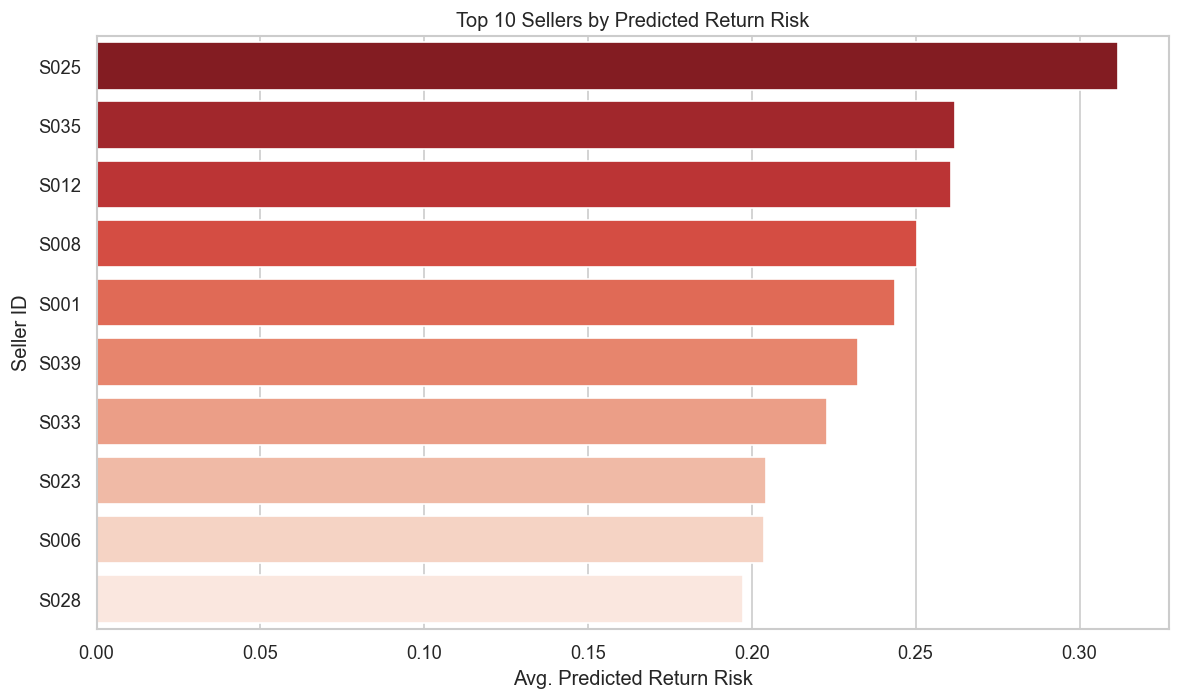

In [64]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_sellers_to_monitor,
    x='avg_predicted_risk',
    y='seller_id',
    hue='seller_id',
    palette='Reds_r',
    dodge=False
)
plt.title("Top 10 Sellers by Predicted Return Risk")
plt.xlabel("Avg. Predicted Return Risk")
plt.ylabel("Seller ID")
plt.tight_layout()
plt.savefig("../visuals/charts/top_seller_risk_phase4.png")
plt.show()

#### Product Category Return Risk

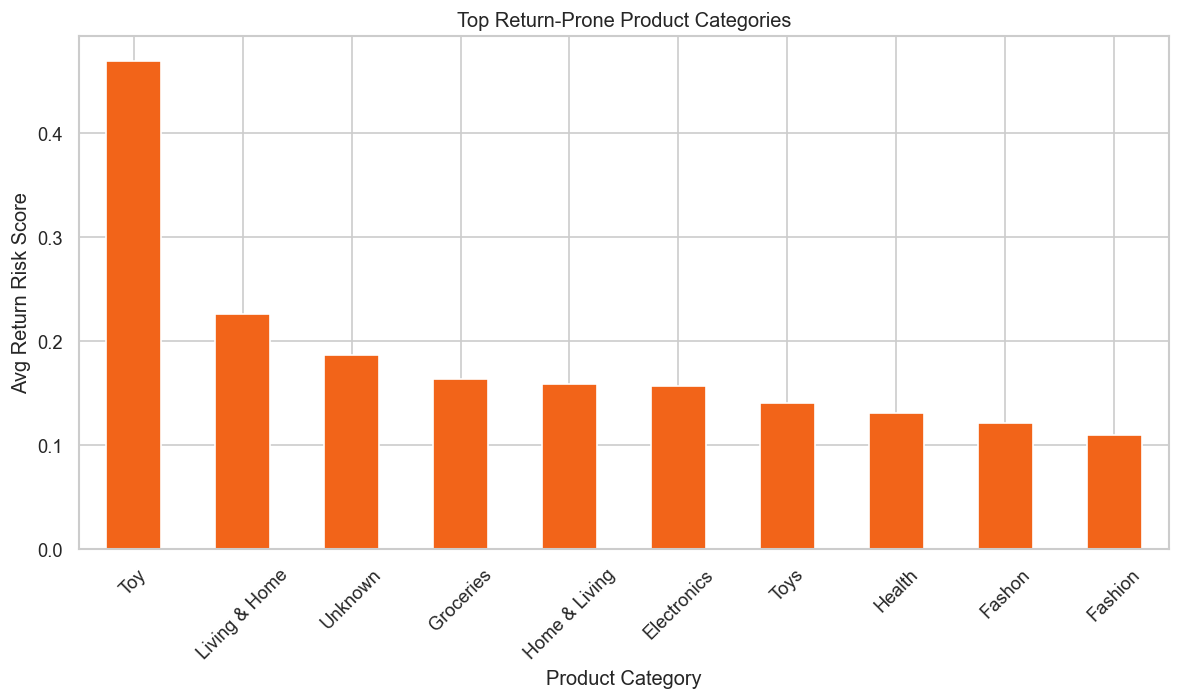

In [65]:
category_risk = df.groupby('product_category')['return_risk_score'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
category_risk.head(10).plot(
    kind='bar', 
    color='#F26419'
)
plt.title("Top Return-Prone Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Avg Return Risk Score")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../visuals/charts/product_category_risk.png")
plt.show()

#### Risk by Customer Rating

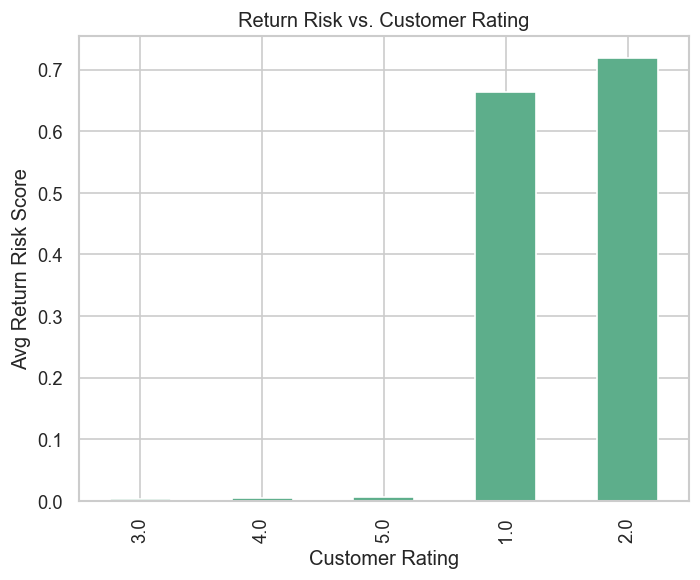

In [66]:
rating_risk = df.groupby('customer_rating')['return_risk_score'].mean().sort_values()

plt.figure(figsize=(6,5))
rating_risk.plot(kind='bar', color='#5DAE8B')
plt.title("Return Risk vs. Customer Rating")
plt.xlabel("Customer Rating")
plt.ylabel("Avg Return Risk Score")
plt.tight_layout()
plt.savefig("../visuals/charts/rating_vs_risk.png")
plt.show()

#### Save Output Files

In [67]:
# Save full return-scored data
df.to_csv("../cleaned/orders_with_return_risk.csv", index=False)

# Save full seller-level risk profile
seller_risk_action.to_csv("../cleaned/seller_risk_action.csv", index=False)

# Save top 10 risky sellers (for quick use)
top_sellers_to_monitor.to_csv("../cleaned/risky_sellers.csv", index=False)

## Phase 4 Summary: Strategic Recommendations & Risk Actions

In this phase, I applied our trained return prediction model to assess the likelihood of each order being returned. These return risk scores helped uncover patterns across sellers, product categories, and customer behavior.

___

### What Was Done

- Flagged individual **high-risk orders** (return probability > 60%)
- Profiled **sellers** based on their share of risky transactions
- Identified **product categories** with consistently high return risks
- Explored how **customer ratings** relate to return likelihood
- Saved key insights and risk profiles for operational planning

___

### What the Data Revealed

#### High-Risk Sellers
> The top 10 sellers had the **highest average predicted return risk**, with some over 40%.  
> These sellers should be prioritized for **quality checks, performance review, or closer monitoring**.

#### Return-Prone Categories
> Categories like **Toys** and **Electronics** showed the **highest return probabilities**.  
> This may point to **quality issues**, **unclear descriptions**, or **expectation mismatches**.

#### Customer Rating Patterns
> There’s a clear link between **low ratings and high return risk**.  
> Customers who rate poorly are significantly more likely to return items — highlighting the importance of **customer satisfaction**.

___

### Recommended Business Actions

- **Seller Monitoring**  
  Flag sellers with **>30% risky orders** for proactive review or support.

- **Risk-Based Alerts**  
  Trigger alerts for **high-risk orders before dispatch** — for manual review or verification.

- **Quality Control Focus**  
  Focus QA efforts on categories with **historically high return rates**.

- **Customer Experience Follow-up**  
  Improve support and resolution for **low-rated or complaint-heavy orders**, which are more likely to be returned.

___

> This phase bridges the gap between machine learning and business action.  
> By using return predictions to guide seller strategy, product QA, and customer service, we reduce preventable returns, protect revenue, and improve customer satisfaction.
